In [1]:
from neuroposelib import read, preprocess, vis, write, features
import numpy as np
import time
from IPython.display import Video
from pathlib import Path
import matplotlib.pyplot as plt
from neuroposelib import DataStruct as ds
from neuroposelib.embed import Embed, Watershed
import pickle
import pywt
%matplotlib inline

analysis_key = "tutorial"
config = read.config("../configs/" + analysis_key + ".yaml")
pose, ids = read.pose_h5("/mnt/home/jwu10/working/neuroposelib/tutorials/demo_mouse/demo_mouse.h5")
connectivity = read.connectivity_config(path=config["skeleton_path"])
meta, meta_by_frame = read.meta("/mnt/home/jwu10/working/neuroposelib/tutorials/demo_mouse/demo_meta.csv", id=ids)

Path(config["out_path"]).mkdir(parents=True, exist_ok=True)

pose_aligned = preprocess.align_floor_by_id(pose=pose, ids=ids, foot_id=12, head_id=0)
pose = preprocess.rotate_spine(preprocess.center_spine(pose_aligned, keypt_idx=4), keypt_idx=[4, 3])

ego_pose, labels = features.get_ego_pose(pose, connectivity.joint_names)

pc_feats, pc_labels = features.pca(
    ego_pose, labels, categories=["ego_euc"], n_pcs=5, method="fbpca"
)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting and rotating the floor for each video to alignment ... 


 50%|█████     | 1/2 [00:00<00:00,  2.46it/s]

Fitting and rotating the floor for each video to alignment ... 


100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Centering poses to mid spine ...
Rotating spine to xz plane ... 
Reformatting pose to egocentric pose features ... 
Calculating principal components ... 


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [51]:
from typing import Optional, Union, List, Tuple, Type
from scipy.signal import morlet2, cwt
from tqdm import tqdm

def wavelet(
    features: np.ndarray,
    labels: List[str],
    ids: Union[np.ndarray, List],
    f_s: int = 90,
    freq: Union[List, np.ndarray] = np.geomspace(1, 25, 25),
    bw: float = 1.0,
):

    print("Calculating wavelets ... ")
    # widths = (w0 * f_s / (2 * freq * np.pi)).astype(features.dtype)
    wlet_feats = np.zeros(
        (features.shape[0], len(freq) * features.shape[1]), features.dtype
    )

    wlet_labels = [
        "_".join(["wlet", label, str(np.round(f, 2))]) for f in freq for label in labels
    ]

    for i in np.unique(ids):
        print("Calculating wavelets for video " + str(i))
        wlets_i_f = np.abs(
            pywt.cwt(
                features[ids == i],
                scales=pywt.frequency2scale("cmor{:.1f}-{:.1f}".format(bw, 1.0), freq)
                * f_s,
                wavelet="cmor{:.1f}-{:.1f}".format(bw, 1.0),
                sampling_period=1 / f_s,
                method="fft",
                axis=0,
            )[0]
        )
        print(wlets_i_f.shape)

        wlet_feats[ids == i] = np.swapaxes(wlets_i_f.T, 0, 1).reshape(
            wlets_i_f.shape[1], -1
        )

    return wlet_feats, wlet_labels

Calculating wavelets ... 
Calculating wavelets for video 0
(25, 324000, 5)
Calculating wavelets for video 1
(25, 324000, 5)
['wlet_ego_euc_pc0_1.0', 'wlet_ego_euc_pc1_1.0', 'wlet_ego_euc_pc2_1.0', 'wlet_ego_euc_pc3_1.0', 'wlet_ego_euc_pc4_1.0', 'wlet_ego_euc_pc0_1.14', 'wlet_ego_euc_pc1_1.14', 'wlet_ego_euc_pc2_1.14', 'wlet_ego_euc_pc3_1.14', 'wlet_ego_euc_pc4_1.14', 'wlet_ego_euc_pc0_1.31', 'wlet_ego_euc_pc1_1.31', 'wlet_ego_euc_pc2_1.31', 'wlet_ego_euc_pc3_1.31', 'wlet_ego_euc_pc4_1.31', 'wlet_ego_euc_pc0_1.5', 'wlet_ego_euc_pc1_1.5', 'wlet_ego_euc_pc2_1.5', 'wlet_ego_euc_pc3_1.5', 'wlet_ego_euc_pc4_1.5', 'wlet_ego_euc_pc0_1.71', 'wlet_ego_euc_pc1_1.71', 'wlet_ego_euc_pc2_1.71', 'wlet_ego_euc_pc3_1.71', 'wlet_ego_euc_pc4_1.71', 'wlet_ego_euc_pc0_1.96', 'wlet_ego_euc_pc1_1.96', 'wlet_ego_euc_pc2_1.96', 'wlet_ego_euc_pc3_1.96', 'wlet_ego_euc_pc4_1.96', 'wlet_ego_euc_pc0_2.24', 'wlet_ego_euc_pc1_2.24', 'wlet_ego_euc_pc2_2.24', 'wlet_ego_euc_pc3_2.24', 'wlet_ego_euc_pc4_2.24', 'wlet_ego_

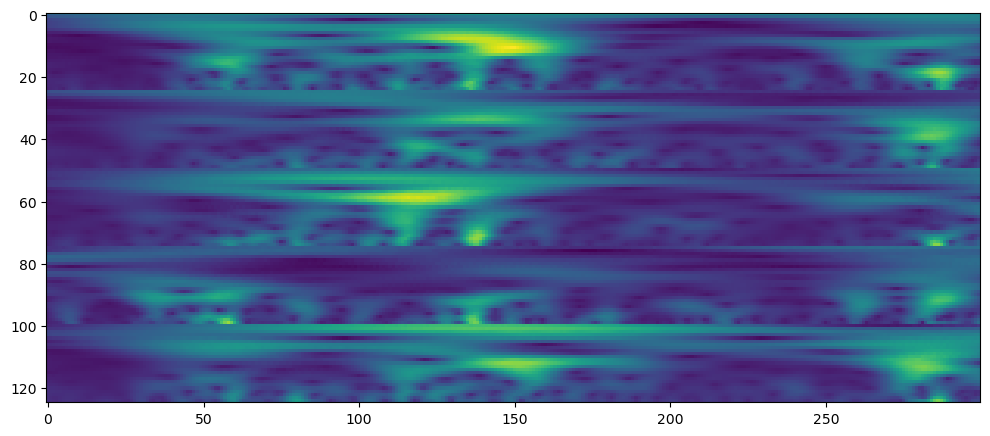

In [54]:
wlet_feats, wlet_labels = wavelet(
    pc_feats, pc_labels, ids, f_s=90, freq=np.geomspace(1, 25, 25), bw=1.0
)
wlet_feats = (wlet_feats - wlet_feats.mean(axis=0)) / wlet_feats.std(axis=0)
print(wlet_labels)
ind = 6000
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 10))
plt.imshow(wlet_feats[ind : ind + 300 : 1, :].T)
f.tight_layout()
plt.show()